In [2]:
# 导入必要的库
import os
import sys
import io
import base64
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont  # 添加ImageDraw和ImageFont的导入
import fitz  # PyMuPDF

# 添加项目根目录到系统路径
project_root = r"D:\workspace\py_projects\embedding_server"
sys.path.append(project_root)

# 导入相关服务
from app.services.pdf_service import PDFService
from app.services.pdf.core import PDFService as PDFCoreService
from app.services.pdf.formula import FormulaExtractor
from app.services.pdf.layout import LayoutAnalyzer
from app.services.pdf.text import TextExtractor
from app.services.pdf.table import TableExtractor

# 设置日志
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
def display_image(image):
    """显示PIL图像或numpy数组图像"""
    plt.figure(figsize=(10, 14))
    if isinstance(image, np.ndarray):
        plt.imshow(image)
    else:
        plt.imshow(np.array(image))
    plt.axis('off')
    plt.show()

In [4]:
def load_test_pdf(pdf_path):
    """加载测试PDF文件"""
    with open(pdf_path, 'rb') as f:
        pdf_content = f.read()
    return pdf_content

# 指定测试PDF路径 - 请替换为您的测试PDF文件
test_pdf_path = project_root + '/examples/2024-Aligning Large Language Models with Humans.pdf'  # 替换为实际路径

In [5]:
# 3. 创建布局信息存储结构和坐标映射
class PDFLayoutInfo:
    """PDF布局信息存储结构"""
    
    def __init__(self, pdf_path=None, pdf_content=None):
        """初始化PDF布局信息"""
        self.pdf_path = pdf_path
        self.pdf_content = pdf_content
        self.pages = []  # 存储所有页面的布局信息
        self.original_sizes = []  # 存储原始PDF页面尺寸
        self.model_sizes = []  # 存储模型处理的尺寸
        self.rendered_sizes = []  # 存储渲染后的图像尺寸
        self.formulas = {}  # 存储公式信息，格式: {页码: [公式列表]}
        self.tables = {}  # 存储表格信息，格式: {页码: [表格列表]}
        self.figures = {}  # 存储图片信息，格式: {页码: [图片列表]}
        
    def add_page(self, page_idx, layout_elements, rendered_size, model_size, original_size=None):
        """添加页面布局信息"""
        # 确保页面索引有效
        while len(self.pages) <= page_idx:
            self.pages.append([])
            self.original_sizes.append(None)
            self.model_sizes.append(None)
            self.rendered_sizes.append(None)
            
        # 存储布局元素和尺寸信息
        self.pages[page_idx] = layout_elements
        self.rendered_sizes[page_idx] = rendered_size
        self.model_sizes[page_idx] = model_size
        if original_size:
            self.original_sizes[page_idx] = original_size
        
    def get_page_layout(self, page_idx):
        """获取指定页面的布局信息"""
        if 0 <= page_idx < len(self.pages):
            return self.pages[page_idx]
        return []
    
    def get_element_by_type(self, page_idx, element_type):
        """获取指定页面中指定类型的所有元素"""
        if 0 <= page_idx < len(self.pages):
            return [elem for elem in self.pages[page_idx] if elem["type"].lower() == element_type.lower()]
        return []
    
    def map_coordinates(self, page_idx, coords, from_model_to_rendered=True):
        """
        映射坐标系统
        
        Args:
            page_idx: 页面索引
            coords: 坐标元组 (x0, y0, x1, y1)
            from_model_to_rendered: 如果为True，从模型坐标映射到渲染坐标；否则反之
            
        Returns:
            映射后的坐标元组
        """
        if 0 <= page_idx < len(self.pages):
            rendered_size = self.rendered_sizes[page_idx]
            model_size = self.model_sizes[page_idx]
            
            if not rendered_size or not model_size:
                return coords
            
            x0, y0, x1, y1 = coords
            
            # 添加偏移校正
            offset_x = int(rendered_size[0])  # 水平偏移校正，约5%
            offset_y = int(rendered_size[1])  # 垂直偏移校正，约5%
            
            if from_model_to_rendered:
                # 从模型坐标映射到渲染坐标
                x_ratio = rendered_size[0] / model_size[0]
                y_ratio = rendered_size[1] / model_size[1]
                
                mapped_x0 = max(0, int(x0 * x_ratio) - offset_x)
                mapped_y0 = max(0, int(y0 * y_ratio) - offset_y)
                mapped_x1 = max(mapped_x0 + 1, min(int(x1 * x_ratio) - offset_x, rendered_size[0]))
                mapped_y1 = max(mapped_y0 + 1, min(int(y1 * y_ratio) - offset_y, rendered_size[1]))
            else:
                # 从渲染坐标映射到模型坐标
                x_ratio = model_size[0] / rendered_size[0]
                y_ratio = model_size[1] / rendered_size[1]
                
                mapped_x0 = int((x0 + offset_x) * x_ratio)
                mapped_y0 = int((y0 + offset_y) * y_ratio)
                mapped_x1 = int((x1 + offset_x) * x_ratio)
                mapped_y1 = int((y1 + offset_y) * y_ratio)
                
            return (mapped_x0, mapped_y0, mapped_x1, mapped_y1)
        
        return coords  # 如果页面索引无效，返回原始坐标
    
    def get_cropped_element(self, page_idx, element_idx, image=None, use_original_coords=True):
        """
        从页面图像中裁剪出指定元素
        
        Args:
            page_idx: 页面索引
            element_idx: 元素索引
            image: 页面图像(PIL Image或numpy数组)，如果为None则需要重新渲染
            use_original_coords: 是否使用原始坐标
            
        Returns:
            裁剪后的图像
        """
        if 0 <= page_idx < len(self.pages) and 0 <= element_idx < len(self.pages[page_idx]):
            element = self.pages[page_idx][element_idx]
            
            # 获取坐标
            if use_original_coords and "original_coordinates" in element:
                coords = element["original_coordinates"]
            else:
                coords = element["coordinates"]
                # 如果需要，转换坐标
                if use_original_coords:
                    coords = self.map_coordinates(page_idx, coords)
                    
            # 确保坐标有效
            x0, y0, x1, y1 = [int(c) for c in coords]
            
            # 如果没有提供图像，尝试重新渲染
            if image is None and self.pdf_content:
                doc = fitz.open(stream=self.pdf_content, filetype="pdf")
                if 0 <= page_idx < len(doc):
                    page = doc[page_idx]
                    pix = page.get_pixmap(matrix=fitz.Matrix(3, 3))
                    img_data = pix.tobytes("png")
                    image = Image.open(io.BytesIO(img_data))
            
            # 裁剪图像
            if image is not None:
                if isinstance(image, np.ndarray):
                    if y1 <= image.shape[0] and x1 <= image.shape[1]:
                        return image[y0:y1, x0:x1]
                else:
                    if y1 <= image.height and x1 <= image.width:
                        return image.crop((x0, y0, x1, y1))
                
        return None
    
    def add_formula(self, page_idx, formula_info):
        """添加公式信息"""
        if page_idx not in self.formulas:
            self.formulas[page_idx] = []
        self.formulas[page_idx].append(formula_info)
    
    def add_table(self, page_idx, table_info):
        """添加表格信息"""
        if page_idx not in self.tables:
            self.tables[page_idx] = []
        self.tables[page_idx].append(table_info)
    
    def add_figure(self, page_idx, figure_info):
        """添加图片信息"""
        if page_idx not in self.figures:
            self.figures[page_idx] = []
        self.figures[page_idx].append(figure_info)
    
    def get_formulas(self, page_idx=None):
        """获取公式信息"""
        if page_idx is not None:
            return self.formulas.get(page_idx, [])
        return self.formulas
    
    def get_tables(self, page_idx=None):
        """获取表格信息"""
        if page_idx is not None:
            return self.tables.get(page_idx, [])
        return self.tables
    
    def get_figures(self, page_idx=None):
        """获取图片信息"""
        if page_idx is not None:
            return self.figures.get(page_idx, [])
        return self.figures
    
    def to_markdown(self, page_idx=None):
        """将PDF内容转换为Markdown格式"""
        markdown = ""
        
        # 处理指定页面或所有页面
        pages_to_process = [page_idx] if page_idx is not None else range(len(self.pages))
        
        for idx in pages_to_process:
            if 0 <= idx < len(self.pages):
                page_markdown = f"## 第 {idx+1} 页\n\n"
                
                # 按照元素在页面中的位置排序（从上到下）
                elements = sorted(self.pages[idx], key=lambda x: x["coordinates"][1])
                
                for element in elements:
                    element_type = element["type"].lower()
                    
                    if element_type == "title":
                        if "extracted_text" in element:
                            page_markdown += f"### {element['extracted_text']}\n\n"
                    
                    elif element_type == "plain text":
                        if "extracted_text" in element:
                            page_markdown += f"{element['extracted_text']}\n\n"
                    
                    elif element_type == "isolate_formula":
                        formula_idx = element.get("formula_idx")
                        if formula_idx is not None and idx in self.formulas:
                            for formula in self.formulas[idx]:
                                if formula.get("element_idx") == formula_idx:
                                    latex = formula.get("latex", "")
                                    page_markdown += f"$$\n{latex}\n$$\n\n"
                                    break
                    
                    elif element_type == "table":
                        table_idx = element.get("table_idx")
                        if table_idx is not None and idx in self.tables:
                            for table in self.tables[idx]:
                                if table.get("element_idx") == table_idx:
                                    table_md = table.get("markdown", "")
                                    page_markdown += f"{table_md}\n\n"
                                    break
                    
                    elif element_type == "figure":
                        figure_idx = element.get("figure_idx")
                        if figure_idx is not None and idx in self.figures:
                            for figure in self.figures[idx]:
                                if figure.get("element_idx") == figure_idx:
                                    img_base64 = figure.get("base64", "")
                                    caption = figure.get("caption", "图片")
                                    page_markdown += f"![{caption}](data:image/png;base64,{img_base64})\n\n"
                                    break
                
                markdown += page_markdown
                
                # 添加页面分隔符
                if idx < len(self.pages) - 1:
                    markdown += "---\n\n"
        
        return markdown

PDF页数: 24


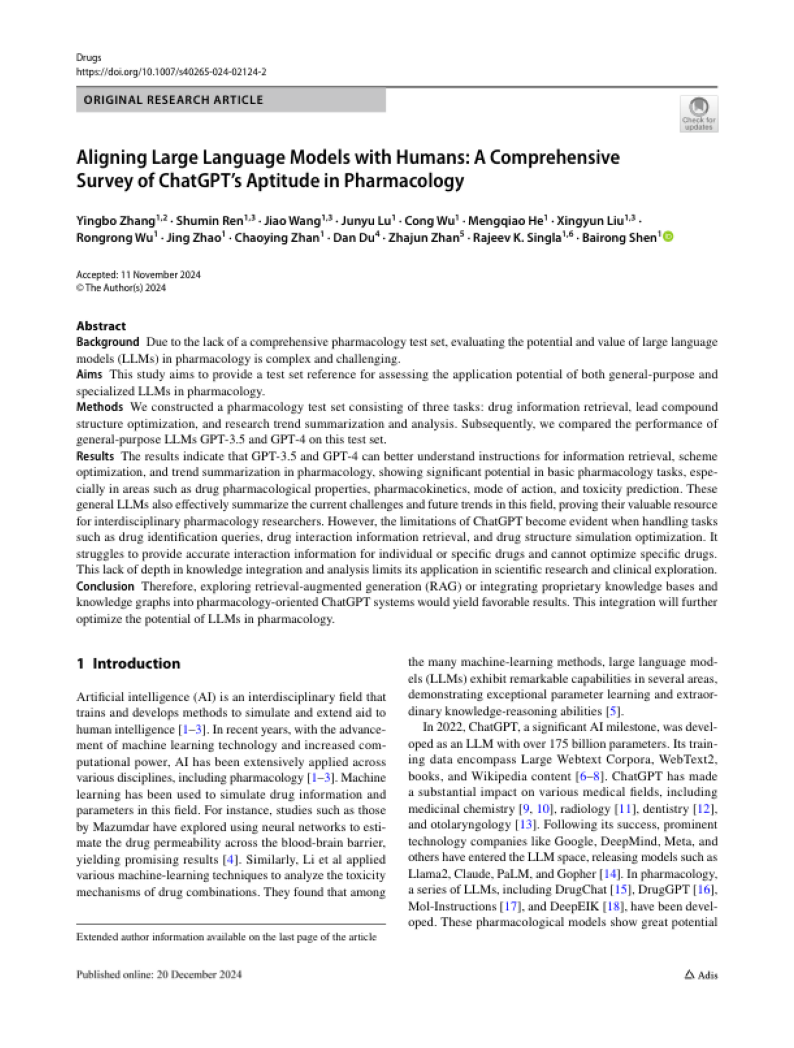

第一页文本前500个字符:
Vol.:(0123456789)
Drugs 
https://doi.org/10.1007/s40265-024-02124-2
ORIGINAL RESEARCH ARTICLE
Aligning Large Language Models with Humans: A Comprehensive 
Survey of ChatGPT’s Aptitude in Pharmacology
Yingbo Zhang1,2 · Shumin Ren1,3 · Jiao Wang1,3 · Junyu Lu1 · Cong Wu1 · Mengqiao He1 · Xingyun Liu1,3 · 
Rongrong Wu1 · Jing Zhao1 · Chaoying Zhan1 · Dan Du4 · Zhajun Zhan5 · Rajeev K. Singla1,6 · Bairong Shen1 
Accepted: 11 November 2024 
© The Author(s) 2024
Abstract
Background  Due to the lack of


In [6]:
# 1. 测试PDF加载和基本信息
def test_pdf_loading(pdf_content):
    """测试PDF加载和基本信息"""
    doc = fitz.open(stream=pdf_content, filetype="pdf")
    print(f"PDF页数: {len(doc)}")
    
    # 显示第一页
    page = doc[0]
    pix = page.get_pixmap()
    img = Image.open(io.BytesIO(pix.tobytes("png")))
    display_image(img)
    
    # 提取基本文本
    text = page.get_text()
    print(f"第一页文本前500个字符:\n{text[:500]}")
    
    return doc

# 加载测试PDF
pdf_content = load_test_pdf(test_pdf_path)
doc = test_pdf_loading(pdf_content)

In [7]:
def extract_image_as_base64(page, bbox):
    """
    从PDF页面提取图片并转换为base64编码
    
    Args:
        page: PDF页面对象
        bbox: 图片边界框
        
    Returns:
        包含图片信息的字典，包括base64编码
    """
    try:
        # 从页面提取图片区域
        rect = fitz.Rect(bbox)
        pix = page.get_pixmap(matrix=fitz.Matrix(2, 2), clip=rect)
        
        # 转换为PIL图像
        img_data = pix.samples
        img = Image.frombytes("RGB", [pix.width, pix.height], img_data)
        
        # 转换为base64
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
        
        return {
            "bbox": bbox,
            "base64": img_base64,
            "width": pix.width,
            "height": pix.height,
            "format": "PNG"
        }
    except Exception as e:
        logging.error(f"图片转base64失败: {str(e)}")
        return None

# 为TextExtractor类添加改进文本空格处理的方法
def improve_text_spacing(self, text):
    """
    改进OCR文本的空格处理
    
    Args:
        text: 原始OCR文本
        
    Returns:
        改进后的文本
    """
    if not text:
        return text
    
    # 1. 在中英文之间添加空格
    import re
    text = re.sub(r'([a-zA-Z0-9])([^\sa-zA-Z0-9])', r'\1 \2', text)
    text = re.sub(r'([^\sa-zA-Z0-9])([a-zA-Z0-9])', r'\1 \2', text)
    
    # 2. 修复多余的空格
    text = re.sub(r'\s+', ' ', text)
    
    # 3. 修复标点符号前的空格
    text = re.sub(r'\s+([,.!?;:])', r'\1', text)
    
    # 4. 确保句子之间有适当的空格
    text = re.sub(r'([.!?])\s*([A-Z])', r'\1 \2', text)
    
    return text.strip()

# 将方法添加到TextExtractor类
TextExtractor.improve_text_spacing = improve_text_spacing

In [8]:
def analyze_pdf_with_elements(pdf_content, max_pages=200):
    """
    增强版PDF布局分析函数，包含公式、表格和图片解析
    
    Args:
        pdf_content: PDF内容（字节流）
        max_pages: 最大处理页数
        
    Returns:
        包含完整布局信息的字典
    """
    # 初始化服务
    pdf_service = PDFCoreService()
    layout_analyzer = LayoutAnalyzer()
    formula_extractor = FormulaExtractor()
    table_extractor = TableExtractor()
    text_extractor = TextExtractor()
    
    # 打开PDF文档
    doc = fitz.open(stream=pdf_content, filetype="pdf")
    total_pages = min(doc.page_count, max_pages)
    
    result = {
        "pages": []
    }
    
    for page_idx in range(total_pages):
        page = doc[page_idx]
        page_result = {
            "page_num": page_idx + 1,
            "width": page.rect.width,
            "height": page.rect.height,
            "blocks": [],
            "formulas": [],
            "tables": [],
            "images": []
        }
        
        # 提取布局信息
        blocks = layout_analyzer.extract_blocks(page)
        
        # 处理每个块
        for block in blocks:
            block_type = block["type"]
            
            if block_type == "text":
                # 提取文本，并确保适当的空格处理
                text = text_extractor.extract_text(page, block["bbox"])
                # 改进OCR文本的空格处理
                text = text_extractor.improve_text_spacing(text)
                block["text"] = text
                page_result["blocks"].append(block)
                
            elif block_type == "formula":
                formula = formula_extractor.extract_formula(page, block["bbox"])
                if formula:
                    page_result["formulas"].append({
                        "bbox": block["bbox"],
                        "latex": formula["latex"],
                        "confidence": formula.get("confidence", 0.0)
                    })
                    
            elif block_type == "table":
                table = table_extractor.extract_table(page, block["bbox"])
                if table and len(table["cells"]) > 0:
                    page_result["tables"].append(table)
                    
            elif block_type == "image":
                # 提取图片并转换为base64编码
                try:
                    image_dict = extract_image_as_base64(page, block["bbox"])
                    if image_dict:
                        page_result["images"].append(image_dict)
                except Exception as e:
                    logging.error(f"提取图片失败: {str(e)}")
        
        result["pages"].append(page_result)
    
    return result



In [9]:
# 4. 增强版PDF布局分析函数，包含公式、表格和图片解析
def analyze_pdf_with_elements(pdf_content, max_pages=200):
    """
    分析PDF布局并解析公式、表格和图片
    
    Args:
        pdf_content: PDF文档的二进制内容
        max_pages: 最大处理页数
        
    Returns:
        PDFLayoutInfo对象，包含布局和元素信息
    """
    # 初始化各种分析器
    layout_analyzer = LayoutAnalyzer(models_dir=os.path.join(project_root, "models"), device="cpu")
    text_extractor = TextExtractor(models_dir=os.path.join(project_root, "models"), device="cpu")
    formula_extractor = FormulaExtractor(models_dir=os.path.join(project_root, "models"), device="cpu")
    table_extractor = TableExtractor(models_dir=os.path.join(project_root, "models"), device="cpu")
    visualizer = PDFVisualization()
    
    # 初始化布局信息存储结构
    layout_info = PDFLayoutInfo(pdf_content=pdf_content)
    
    # 打开PDF
    doc = fitz.open(stream=pdf_content, filetype="pdf")
    total_pages = len(doc)
    print(f"PDF总页数: {total_pages}")
    
    # 处理所有页面（或最多max_pages页）
    pages_to_process = min(max_pages, total_pages)
    
    for page_idx in range(pages_to_process):
        print(f"\n处理第 {page_idx+1}/{pages_to_process} 页")
        page = doc[page_idx]
        
        # 获取原始页面尺寸
        original_size = (page.rect.width, page.rect.height)
        print(f"原始页面尺寸: {original_size}")
        
        # 渲染页面为图像
        pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))  # 使用2x缩放获得更清晰的图像
        img_data = pix.tobytes("png")
        img = Image.open(io.BytesIO(img_data))
        img_np = np.array(img)
        
        
        # 获取渲染后的图像尺寸
        rendered_size = (img.width, img.height)
        print(f"渲染后图像尺寸: {rendered_size}")
        
        # 分析布局
        layout_results = layout_analyzer.analyze_page(img_np)
        print(f"第 {page_idx+1} 页检测到的布局元素数量: {len(layout_results)}")
        
        # 获取模型处理的尺寸
        model_size = (800, 1024)
        if hasattr(layout_analyzer, 'model_input_size'):
            model_size = layout_analyzer.model_input_size
        
        # 存储布局信息
        layout_info.add_page(page_idx, layout_results, rendered_size, model_size, original_size)
        
        # 创建可视化图像
        layout_img = img.copy()
        draw = ImageDraw.Draw(layout_img)
        
        # 为不同类型的元素使用不同颜色
        colors = {
            "plain text": (0, 200, 0),      # 绿色
            "title": (255, 0, 0),           # 红色
            "figure": (0, 0, 255),          # 蓝色
            "table": (255, 165, 0),         # 橙色
            "table_caption": (255, 135, 0), # 深橙色
            "table_footnote": (255, 100, 0),# 红橙色
            "isolate_formula": (128, 0, 128), # 紫色
            "list": (0, 255, 255),          # 青色
            "figure_caption": (0, 20, 45),  # 深蓝色
            "abandon": (100, 100, 100),     # 灰色
        }
        
        # 尝试加载字体
        try:
            font = ImageFont.truetype("Arial.ttf", 24)
        except:
            font = ImageFont.load_default()
        
        print(f"第 {page_idx+1} 页检测到的元素类型:")
        for i, block in enumerate(layout_results):
            
            block_type = block["type"].lower()  # 转为小写以匹配颜色字典
            print(f"{i+1}. {block_type}")
            
            # 获取模型坐标
            x0, y0, x1, y1 = block["coordinates"]
            
            # 映射到渲染坐标
            # mapped_coords = layout_info.map_coordinates(page_idx, model_coords)
            # x0, y0, x1, y1 = mapped_coords
            
            # 更新block中的坐标为映射后的坐标
            # block["original_coordinates"] = mapped_coords
            mapped_coords = block["coordinates"]
            # 绘制边界框
            line_width = max(3, int(min(rendered_size) / 300))
            color = colors.get(block_type, (0, 0, 200))
            draw.rectangle([x0, y0, x1, y1], outline=color, width=line_width)
            
            # 添加标签
            
            confidence = block.get("confidence", 0)
            label = f"{i+1}.{block_type} ({confidence:.2f})"
            text_bbox = draw.textbbox((x0, y0), label, font=font)
            draw.rectangle(text_bbox, fill=(255, 255, 255, 200))
            draw.text((x0, y0-15), label, fill=color, font=font)
            
            # 裁剪区域
            try:
                crop_img = img.crop((x0, y0, x1, y1))
                crop_img_np = np.array(crop_img)
            except Exception as e:
                print(f"  裁剪失败: {e}")
                continue
            
            # 根据元素类型进行不同处理
            if block_type in ["plain text", "title"]:
                # 提取文本
                try:
                    extracted_text = text_extractor.extract_text(crop_img_np)
                    if extracted_text:
                        block["extracted_text"] = extracted_text
                        print(f"  文本: {extracted_text[:100]}{'...' if len(extracted_text) > 100 else ''}")
                except Exception as e:
                    print(f"  文本提取失败: {e}")
            
            elif block_type == "isolate_formula":
                # 提取公式
                try:
                    latex = formula_extractor.recognize_formula(crop_img_np)
                    if latex:
                        formula_info = {
                            "element_idx": i,
                            "coordinates": mapped_coords,
                            "latex": latex,
                            "confidence": confidence
                        }
                        layout_info.add_formula(page_idx, formula_info)
                        block["formula_idx"] = i
                        print(f"  公式: {latex[:100]}{'...' if len(latex) > 100 else ''}")
                except Exception as e:
                    print(f"  公式提取失败: {e}")
            
            elif block_type == "table":
                # 提取表格
                try:
                    table_markdown = table_extractor.extract_table(crop_img_np)
                    if not table_markdown:
                        # 如果高级表格识别失败，回退到基本方法
                        table_markdown = table_extractor.extract_table_basic(page, mapped_coords)
                    
                    if table_markdown:
                        table_info = {
                            "element_idx": i,
                            "coordinates": mapped_coords,
                            "markdown": table_markdown,
                            "confidence": confidence
                        }
                        layout_info.add_table(page_idx, table_info)
                        block["table_idx"] = i
                        print(f"  表格: {table_markdown[:100]}{'...' if len(table_markdown) > 100 else ''}")
                except Exception as e:
                    print(f"  表格提取失败: {e}")
            
            elif block_type == "figure":
                # 处理图片
                try:
                    img_base64 = visualizer.image_to_base64(crop_img)
                    figure_info = {
                        "element_idx": i,
                        "coordinates": mapped_coords,
                        "base64": img_base64,
                        "confidence": confidence,
                        "caption": "图片"
                    }
                    
                    # 尝试提取图片中的文本作为可能的标题
                    try:
                        img_text = text_extractor.extract_text(crop_img_np)
                        if img_text:
                            figure_info["caption"] = img_text
                    except:
                        pass
                    
                    layout_info.add_figure(page_idx, figure_info)
                    block["figure_idx"] = i
                    print(f"  图片已提取")
                except Exception as e:
                    print(f"  图片处理失败: {e}")
        
        # 显示带有布局标注的图像
        plt.figure(figsize=(15, 20))
        plt.imshow(layout_img)
        plt.title(f"第 {page_idx+1} 页布局分析", fontsize=16)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # 显示提取的内容统计
        print("\n提取内容统计:")
        print(f"  文本块: {len([b for b in layout_results if b['type'].lower() in ['plain text', 'title']])}")
        print(f"  公式: {len(layout_info.get_formulas(page_idx))}")
        print(f"  表格: {len(layout_info.get_tables(page_idx))}")
        print(f"  图片: {len(layout_info.get_figures(page_idx))}")
    
    return layout_info

# 测试增强版PDF布局分析
pdf_layout_info = analyze_pdf_with_elements(pdf_content)

INFO:app.services.pdf.layout:布局模型加载成功: D:\workspace\py_projects\embedding_server\models\layout/DocLayout-YOLO_ft/yolov10l_ft.pt
INFO:app.services.pdf.layout:布局模型输入尺寸: (800, 1024)


KeyboardInterrupt: 

In [ ]:
# 测试公式识别功能
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import os

# 初始化公式提取器
formula_extractor = FormulaExtractor(models_dir="/Users/acproject/workspace/python_projects/embedding_server/models")

# 测试图片路径
test_image_path = r"/Users/acproject/workspace/python_projects/embedding_server/examples/0000001.png"

# 检查图片是否存在
if not os.path.exists(test_image_path):
    print(f"错误：图片不存在 - {test_image_path}")
else:
    # 读取图片并显示
    img = Image.open(test_image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.array(img))
    plt.title("原始图片")
    plt.axis('off')
    plt.show()
    
    # 运行公式检测和识别
    results = formula_extractor.test_formula_from_image(test_image_path)
    
    # 打印检测结果
    print(f"检测到 {results['detection']['count']} 个公式")
    
    # 如果检测到公式，显示检测结果
    if results['detection']['count'] > 0:
        # 创建一个副本用于绘制边界框
        img_with_boxes = img.copy()
        draw = ImageDraw.Draw(img_with_boxes)
        
        # 绘制每个检测到的公式的边界框
        for i, box_info in enumerate(results['detection']['boxes']):
            bbox = box_info['bbox']
            x1, y1, x2, y2 = bbox
            
            # 绘制矩形框
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
            
            # 添加标签
            label = f"{i+1}: 公式"
            draw.text((x1, y1-20), label, fill="red")
        
        # 显示带边界框的图片
        plt.figure(figsize=(10, 10))
        plt.imshow(np.array(img_with_boxes))
        plt.title("检测结果")
        plt.axis('off')
        plt.show()
        
        # 显示识别结果
        print("\n识别结果:")
        for i, formula in enumerate(results['recognition']['formulas']):
            print(f"公式 {i+1}:")
            print(f"  坐标: {formula['bbox']}")
            print(f"  文本: {formula['text']}")
            print(f"  置信度: {formula['confidence']:.2f}")
            
            # 提取并显示单个公式图像
            x1, y1, x2, y2 = formula['bbox']
            formula_img = np.array(img)[int(y1):int(y2), int(x1):int(x2)]
            
            plt.figure(figsize=(5, 5))
            plt.imshow(formula_img)
            plt.title(f"公式 {i+1}")
            plt.axis('off')
            plt.show()
    else:
        print("未检测到公式")

In [ ]:
# 测试公式识别功能
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import os

# 初始化公式提取器
formula_extractor = FormulaExtractor(models_dir="/Users/acproject/workspace/python_projects/embedding_server/models")

# 测试图片路径
test_image_path = r"/Users/acproject/workspace/python_projects/embedding_server/examples/0002.png"

# 检查图片是否存在
if not os.path.exists(test_image_path):
    print(f"错误：图片不存在 - {test_image_path}")
else:
    # 读取图片并显示
    img = Image.open(test_image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.array(img))
    plt.title("原始图片")
    plt.axis('off')
    plt.show()
    
    # 运行公式检测和识别
    results = formula_extractor.test_formula_from_image(test_image_path)
    
    # 打印检测结果
    print(f"检测到 {results['detection']['count']} 个公式")
    
    # 如果检测到公式，显示检测结果
    if results['detection']['count'] > 0:
        # 创建一个副本用于绘制边界框
        img_with_boxes = img.copy()
        draw = ImageDraw.Draw(img_with_boxes)
        
        # 绘制每个检测到的公式的边界框
        for i, box_info in enumerate(results['detection']['boxes']):
            bbox = box_info['bbox']
            x1, y1, x2, y2 = bbox
            
            # 绘制矩形框
            draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
            
            # 添加标签
            label = f"{i+1}: 公式"
            draw.text((x1, y1-20), label, fill="red")
        
        # 显示带边界框的图片
        plt.figure(figsize=(10, 10))
        plt.imshow(np.array(img_with_boxes))
        plt.title("检测结果")
        plt.axis('off')
        plt.show()
        
        # 显示识别结果
        print("\n识别结果:")
        for i, formula in enumerate(results['recognition']['formulas']):
            print(f"公式 {i+1}:")
            print(f"  坐标: {formula['bbox']}")
            print(f"  文本: {formula['text']}")
            print(f"  置信度: {formula['confidence']:.2f}")
            
            # 提取并显示单个公式图像
            x1, y1, x2, y2 = formula['bbox']
            formula_img = np.array(img)[int(y1):int(y2), int(x1):int(x2)]
            
            plt.figure(figsize=(5, 5))
            plt.imshow(formula_img)
            plt.title(f"公式 {i+1}")
            plt.axis('off')
            plt.show()
    else:
        print("未检测到公式")